### Fractional derivative

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import math
from math import exp as exp
import numpy as np
from pyfod.fod import caputo
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

In [3]:
from pyfod.fod import caputo

In [10]:
class memristor_fractional:
    u_Voltage=0
    u_Hz=0
    q=1
    gamma1=0
    gamma2=0
    delta1=0
    delta2=0
    x_p=0
    x_n=0
    A_p=0
    A_n=0
    V_p=0
    V_n=0
    x_arr=[]
    t_arr=[]
    u_arr=[]
    i_arr=[]
    counter=0
    x0=2
    from_number=0
    to_number=1
    amount=20
    
    alpha = 1
    x1=0
    
    
    def clean(self):
        self.x_arr=[]
        self.t_arr=[]
        self.u_arr=[]
        self.i_arr=[]
        self.counter=0
        
    def set_params(self, u_Voltage, u_Hz, q, gamma1, gamma2, delta1, delta2, x_p, x_n,  A_p, A_n, V_p, V_n, x0, from_number, to_number, amount, alpha):
        self.clean()
        
        
        self.u_Voltage=u_Voltage
        self.u_Hz = u_Hz
        self.q=q
        self.gamma1=gamma1
        self.gamma2=gamma2
        self.delta1=delta1
        self.delta2=delta2
        self.x_p=x_p
        self.x_n=x_n
        self.A_p=A_p
        self.A_n=A_n
        self.V_p=V_p
        self.V_n=V_n
        
        self.x0=x0
        self.to_number=to_number
        self.from_number=from_number
        self.amount=amount
        
        self.alpha = alpha 
        # compute
        self.compute_state_equation()
        self.compute_current_voltage()
        

    def u(self, t):
        return self.u_Voltage*np.sin(2*math.pi*self.u_Hz*t)
    
    def exp_q(self, xx):
        if self.q==1:
            return exp(xx)
        elif (1+(1-self.q)*xx)>0:
            return (1+(1-self.q)*xx)**(1/(1-self.q))
        else:
            return 0
        
    def sinh_q(self, xx):
        return 0.5*(self.exp_q(xx)-self.exp_q(-1*xx))

    # u, x - functions with one single argument t
    def i(self, t):
        return self.gamma1*self.x(t)*self.sinh_q(self.delta1*self.u(t)) + self.gamma2*(1-self.x(t))*self.sinh_q(self.delta2*self.u(t))
    
    def w_p(self, x1, t):
        return 1+(self.x_p-x1)/(1-self.x_p)
    
    def w_n(self, x1, t):
        return x1/(1-self.x_n)
    
    # u,x - function with one single argument t
    def f(self, x1, t):
        if self.u(t) > 0:
            if x1>=self.x_p:
                #print(1)
                return exp(-1*(x1-self.x_p))*self.w_p(x1, t)
            else:
                #print(2)
                return 1
        else:
            if x1<=(1-self.x_n):
                #print(3)
                return exp(x1+self.x_n-1)*self.w_n(x1, t)
            else:
                #print(4)
                return 1
            
    def g(self, t):
        if self.u(t) > self.V_p:
            return self.A_p * (exp(self.u(t)) - exp(self.V_p))
        elif self.u(t)<(-1*self.V_n):
            return -1*self.A_n * (exp(-1*self.u(t)) - exp(self.V_n))
        else:
            return 0
    
    def func_caputo(self, t):
        return self.g(t) * self.f(self.x1, t)
    
    def dxdt(self, x1, t):
        self.x1=x1
        res=caputo(f=np.vectorize(self.func_caputo), alpha=1-self.alpha, lower=0, upper=t, quadrature='rs', n=300)['fd']
        #print(res, self.func_caputo(t), self.counter)
        self.counter = self.counter+1
        return res
        #return self.func_caputo(t)
    
    # computations---------------------------------------------------------------------------------------
    def compute_state_equation(self):
        t_arr = np.linspace(self.from_number, self.to_number, self.amount) # vector of time
        self.t_arr=t_arr
        x_arr = odeint(self.dxdt, self.x0, t_arr) # solve eq.
        x_arr = np.array(x_arr).flatten()
        self.x_arr=x_arr
        #for t in self.t_arr:
            #self.x_arr.append(self.u(t))
        
    def x(self, t):
        ind = list(self.t_arr).index(t)
        return self.x_arr[ind]
    
    def compute_current_voltage(self):
        for t in self.t_arr:
            self.i_arr.append(self.i(t))
            self.u_arr.append(self.u(t))

In [11]:
def current_voltage_plot_fractional(u_Voltage, u_Hz, q, gamma1, gamma2, delta1, delta2, x_p, x_n, A_p, A_n, V_p, V_n, from_number, to_number, amount, alpha, x0, color):
    print(u_Voltage, u_Hz, q, gamma1, gamma2, delta1, delta2, x_p, x_n,  A_p, A_n, V_p, V_n, x0, from_number, to_number, amount, alpha, color)
    memristor1.set_params(u_Voltage, u_Hz, q, gamma1, gamma2, delta1, delta2, x_p, x_n,  A_p, A_n, V_p, V_n, x0, from_number, to_number, amount, alpha)
    plt.clf()
    plt.plot(memristor1.u_arr, memristor1.i_arr, 'o-', color=color) 
    plt.title(f'Model with derivative order = {alpha}')
    plt.xlabel('Voltage')
    plt.ylabel('Current')

memristor1=memristor_fractional()
interact_manual(current_voltage_plot_fractional, \
         u_Voltage=6.0, u_Hz=1, q=0.726, gamma1=0.227, gamma2=0.001,\
         delta1=1.021, delta2=5.373,\
         x_p=0.21, x_n=0.571,  A_p=0.321, A_n=0.049,\
         V_p=4.543, V_n=0.0,\
         from_number=0.0, to_number=1, amount=(0, 100), alpha=0.95,\
         x0=(0,5,0.1),\
         color=["orange","red","yellow"])

interactive(children=(FloatSlider(value=6.0, description='u_Voltage', max=18.0, min=-6.0), IntSlider(value=1, …

<function __main__.current_voltage_plot_fractional(u_Voltage, u_Hz, q, gamma1, gamma2, delta1, delta2, x_p, x_n, A_p, A_n, V_p, V_n, from_number, to_number, amount, alpha, x0, color)>

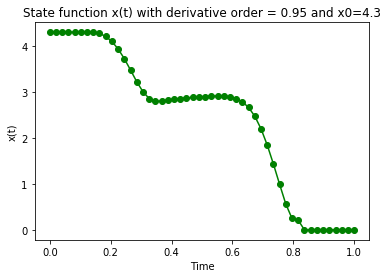

In [14]:
plt.plot(memristor1.t_arr, memristor1.x_arr, 'o-', color='green') 
plt.title(f'State function x(t) with derivative order = {memristor1.alpha} and x0={memristor1.x0}')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.show()

Text(0.5, 0, 'time, s')

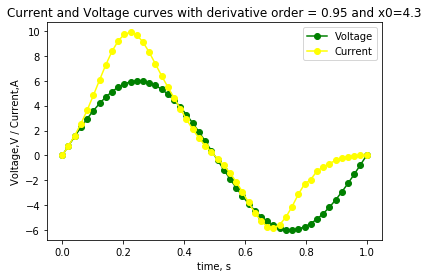

In [15]:
plt.plot(memristor1.t_arr, memristor1.u_arr, '-o', color='green', label='Voltage')
plt.plot(memristor1.t_arr, memristor1.i_arr, '-o', color='yellow', label='Current')
plt.title(f'Current and Voltage curves with derivative order = {memristor1.alpha} and x0={memristor1.x0}')
plt.legend()
plt.ylabel('Voltage,V / Current,A')
plt.xlabel('time, s')